In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import xgboost as xgb

%matplotlib inline

In [2]:
solos_df = pd.read_csv('wrangled_train_solos_df.csv', index_col=0)

In [3]:
X = solos_df.drop(['Id', 'winPlacePerc'], axis=1)
y = solos_df['winPlacePerc']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)

# Random Forest

Starting the in-depth analysis with Random Forest Regression. This form of regression is one of the most accurate forms of Machine Learning modeling, however it comes at the price of time. RF Regression takes booststrap aggregation and dials it up to give make each tree in the forest a good predictor of the target variable. Having a large forest means getting more accurate data, so let's look for a number of trees between 10 and 100 (only going by 10's) to see if we can get a good model going. Another parameter we will be looking in to is max_depth. Max depth will allow each tree to be more accurate and capture more of the data, thus providing a better model overall.

In [4]:
steps = [('rf', RandomForestRegressor(random_state=11))]
param_grid = {'rf__n_estimators': np.arange(10, 110, 10), 'rf__max_depth' : np.arange(10, 110, 10)}
pipeline = Pipeline(steps)
cv = GridSearchCV(pipeline, param_grid, cv = 5)
cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('rf',
                                        RandomForestRegressor(bootstrap=True,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                              min_samples_split=2,
                                                              min_weight_fraction_leaf=0.0,
                       

In [5]:
cv.best_params_

{'rf__max_depth': 20, 'rf__n_estimators': 100}

In [6]:
best_max_depth = cv.best_params_['rf__max_depth']
best_n_estimators = cv.best_params_['rf__n_estimators']

Now that we have our best parameters for the RF Regressor, we can plug those in one more time and fit and predict the data.

In [7]:
rf = RandomForestRegressor(max_depth=best_max_depth, n_estimators=best_n_estimators, random_state=11)
rf_fit = rf.fit(X_train, y_train)
rf_predict = rf.predict(X_test)

In [8]:
compare = y_test.to_frame()
compare['rf_predict'] = rf_predict
compare.head()

,winPlacePerc,rf_predict
710443,0.7020,0.733021
625623,0.1458,0.157514
696302,0.7350,0.635308
264598,0.4375,0.389281
5674,0.9680,0.946686


In [9]:
training_accuracy = rf.score(X_train, y_train)
test_accuracy = rf.score(X_test, y_test)

print(f"Accuracy on training data: {training_accuracy}")
print(f"Accuracy on test data:     {test_accuracy}")

Accuracy on training data: 0.983625315596857
Accuracy on test data:     0.9564313763954715


The score here is really good. 95% test accuracy is fantastic. Seems like RF Regression was a good choice for the data, even if the original search for optimal hyperparameters took a while.

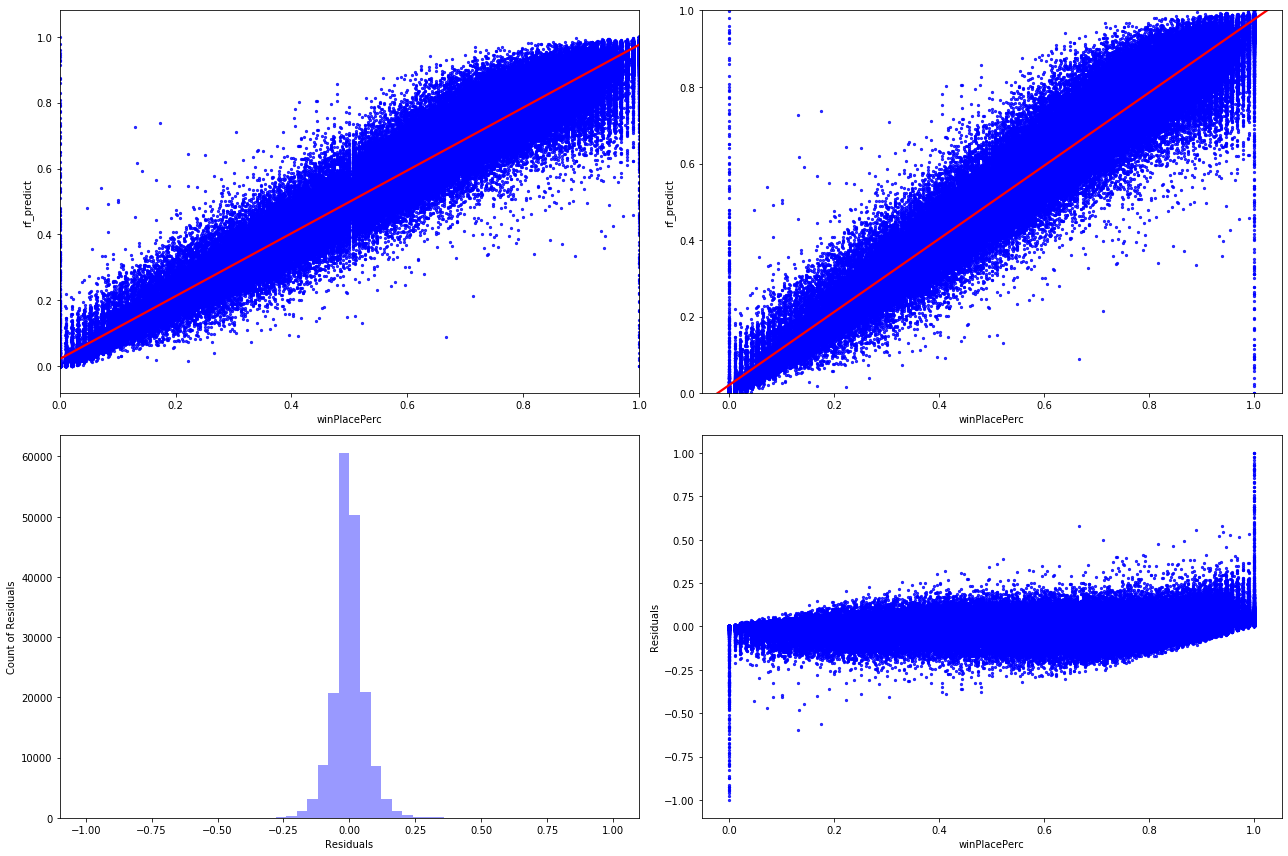

In [10]:
fig, axes = plt.subplots(2,2, figsize=(18,12))
axes = axes.flatten()
sns.regplot(x='winPlacePerc', y='rf_predict', data=compare, color='blue', ax=axes[0], scatter_kws={'s':5}, line_kws={'color': 'red'})
axes[0].set_xlim((0,1))
sns.regplot(x='winPlacePerc', y='rf_predict', data=compare, color='blue', ax=axes[1], scatter_kws={'s':5}, line_kws={'color': 'red'})
axes[1].set_ylim((0,1))
sns.distplot(y_test - rf_predict, ax=axes[2], kde=False, color='blue')
axes[2].set_xlabel('Residuals')
axes[2].set_ylabel('Count of Residuals')
sns.regplot(y_test, y_test - rf_predict, ax=axes[3], fit_reg=False, color='blue', scatter_kws={'s':5})
axes[3].set_ylabel('Residuals')

fig.tight_layout()
plt.show()

Graphs look great, though we would expect them to with a 95% accuracy on the data. Seems like RF Regression took the bounds of 0 and 1 in to account, not letting the predictions go above 1 or below 0. Next let's take a look at feature importance, to see how each feature impacted the final prediction.

In [11]:
feature_importances = pd.DataFrame(pd.Series(rf.feature_importances_), columns=['Importance'])
feature_importances.index = X.columns
feature_importances = feature_importances.sort_values('Importance', ascending=False)
feature_importances

,Importance
walkDistance,0.773872
killPlace,0.157430
numGroups,0.014581
matchDuration,0.013173
boosts,0.007306
maxPlace,0.005465
rideDistance,0.004828
kills,0.004250
damageDealt,0.003992
weaponsAcquired,0.003345


In [12]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print(indices)

[19  5 12 10  1 11 14  7  2 20  8  9 13  4 21  6 16  3  0 17 15 18]


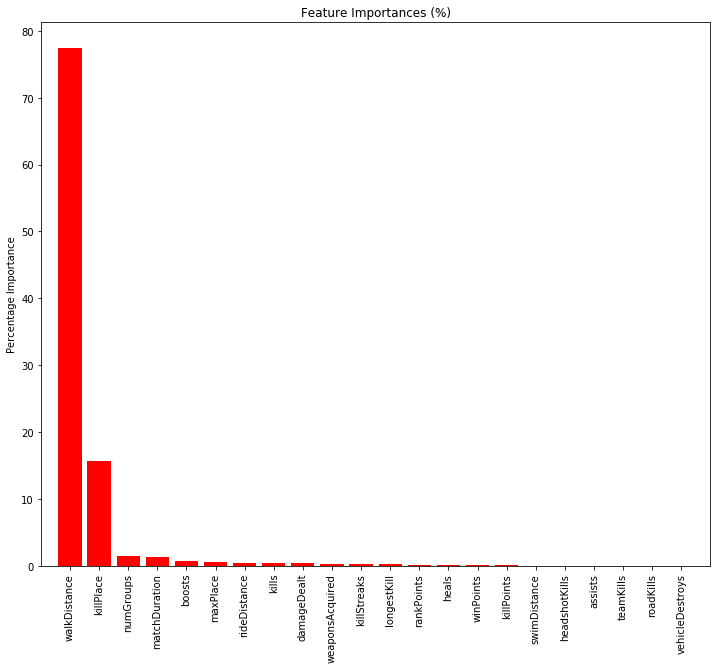

In [13]:
plt.figure(figsize=(12,10))
plt.title("Feature Importances (%)")
plt.bar(range(X.shape[1]), importances[indices] * 100, color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feature_importances.index, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.ylabel('Percentage Importance')
plt.show()

Something I didn't expect here. Apparently walk distance is a pretty huge factor in predicting for RF Regression. Something I never would have expected to be so important. Random Forest also has a hyperparameter max_features. Let's see if changing that to sqrt or log2 will give us a better score on the data.

In [14]:
max_features_list = ['auto', 'sqrt', 'log2']

for m in max_features_list:
    rf = RandomForestRegressor(max_depth=best_max_depth, n_estimators=best_n_estimators, max_features=m)
    rf_fit = rf.fit(X_train, y_train)
    rf_predict = rf.predict(X_test)
    
    training_accuracy = rf.score(X_train, y_train)
    test_accuracy = rf.score(X_test, y_test)
    
    print(f'Feature type: {m}')
    print(f"Accuracy on training data: {training_accuracy}")
    print(f"Accuracy on test data:     {test_accuracy}")
    print('\n')

Feature type: auto
Accuracy on training data: 0.9836043149263172
Accuracy on test data:     0.9565320696548042


Feature type: sqrt
Accuracy on training data: 0.9772125592204215
Accuracy on test data:     0.954421124149701


Feature type: log2
Accuracy on training data: 0.9772359679616907
Accuracy on test data:     0.9542078012194966




Doesn't seem to. max_features of auto turns out to give us the best score. However, that doesn't mean we can't learn something from looking at the feature importances of the other two regressors anyway.

In [15]:
rf = RandomForestRegressor(max_depth=best_max_depth, n_estimators=best_n_estimators, random_state=11, max_features='sqrt')
rf_fit = rf.fit(X_train, y_train)
feature_importances = pd.DataFrame(pd.Series(rf.feature_importances_), columns=['Importance'])
feature_importances.index = X.columns
feature_importances = feature_importances.sort_values('Importance', ascending=False)
feature_importances

,Importance
walkDistance,0.331345
killPlace,0.233430
weaponsAcquired,0.111284
boosts,0.108333
heals,0.048143
longestKill,0.032765
kills,0.025521
killStreaks,0.019805
rideDistance,0.018297
damageDealt,0.017650


In [16]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print(indices)

[19  5 20  1  4  9  7  8 14  2 10 12 11 16  3 21 13  6  0 17 15 18]


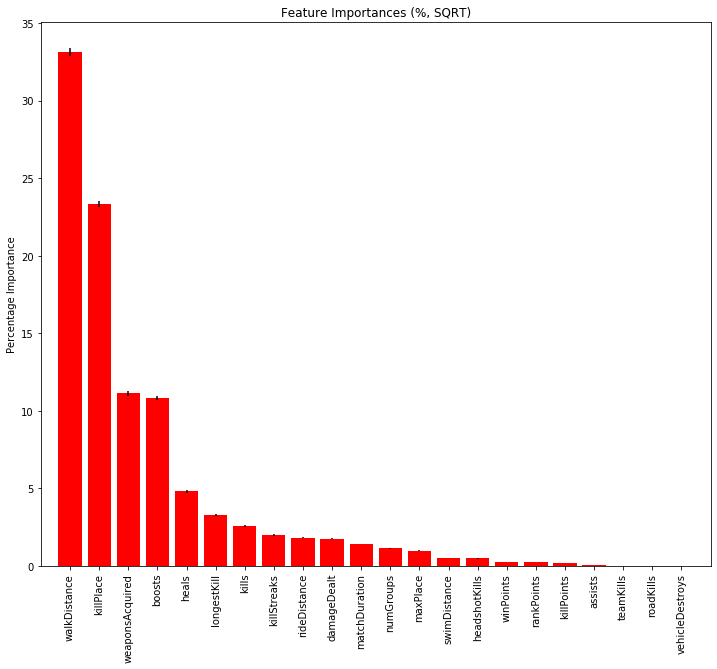

In [17]:
plt.figure(figsize=(12,10))
plt.title("Feature Importances (%, SQRT)")
plt.bar(range(X.shape[1]), importances[indices] * 100, color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feature_importances.index, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.ylabel('Percentage Importance')
plt.show()

In [18]:
rf = RandomForestRegressor(max_depth=20, n_estimators=90, random_state=11, max_features='log2')
rf_fit = rf.fit(X_train, y_train)
feature_importances = pd.DataFrame(pd.Series(rf.feature_importances_), columns=['Importance'])
feature_importances.index = X.columns
feature_importances = feature_importances.sort_values('Importance', ascending=False)
feature_importances

,Importance
walkDistance,0.338668
killPlace,0.221553
weaponsAcquired,0.118326
boosts,0.100312
heals,0.052657
longestKill,0.034514
kills,0.025098
killStreaks,0.018903
rideDistance,0.018513
damageDealt,0.017763


In [19]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print(indices)

[19  5 20  1  4  9  7  8 14  2 10 12 11 16  3 21 13  6  0 17 15 18]


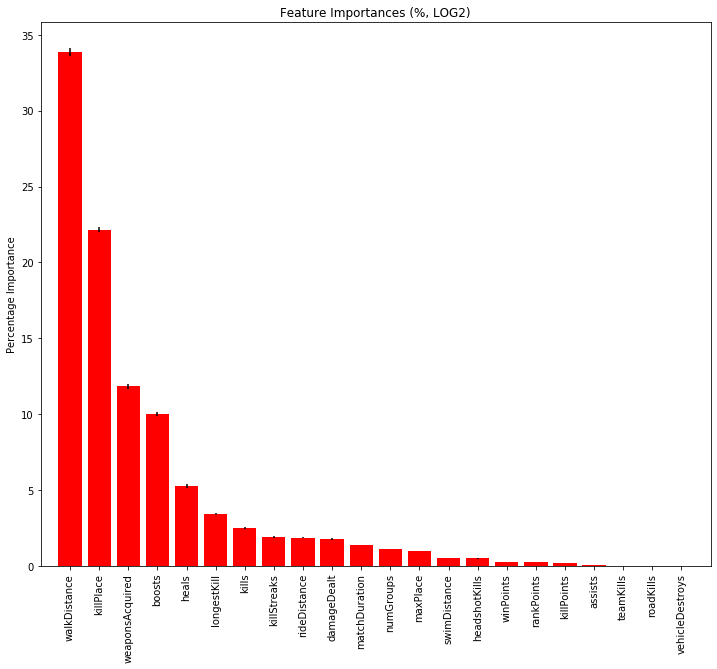

In [20]:
plt.figure(figsize=(12,10))
plt.title("Feature Importances (%, LOG2)")
plt.bar(range(X.shape[1]), importances[indices] * 100, color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feature_importances.index, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.ylabel('Percentage Importance')
plt.show()

So walkDistance is still the biggest factor with the other two types of max_features, though only about half as much as a max_feature of auto. It's certainly interesting to see how feature importance changes with the change of a single hyperparameter. It still shows that random forest regression has a strange obsession with walk distance though.

# XGBoost

The final type of regression we'll look into is Gradient Boosting. This is another type of random forest regression, where each new tree is based on the success or failure of the tree made before it. So it helps correct errors in previous trees as the model goes on. Let's see if it will have any more success with our data over RF Regression

In [21]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=2000)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

C:\Users\David C. Buehler\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [22]:
training_accuracy = xgb_model.score(X_train, y_train)
test_accuracy = xgb_model.score(X_test, y_test)

print(f"Accuracy on training data: {training_accuracy}")
print(f"Accuracy on test data:     {test_accuracy}")

Accuracy on training data: 0.9609340272838749
Accuracy on test data:     0.959478053989789


Overall it seems to have performed about the same as the random forest model. Though slightly worse on the training set. Seems that there isn't much different between XGBoost and RF Regression in the case of this data set.

In [23]:
xgb_compare = y_test.to_frame()
xgb_compare['xgb_predict'] = xgb_pred
xgb_compare.head()

,winPlacePerc,xgb_predict
710443,0.7020,0.702757
625623,0.1458,0.152383
696302,0.7350,0.665318
264598,0.4375,0.382190
5674,0.9680,0.926180


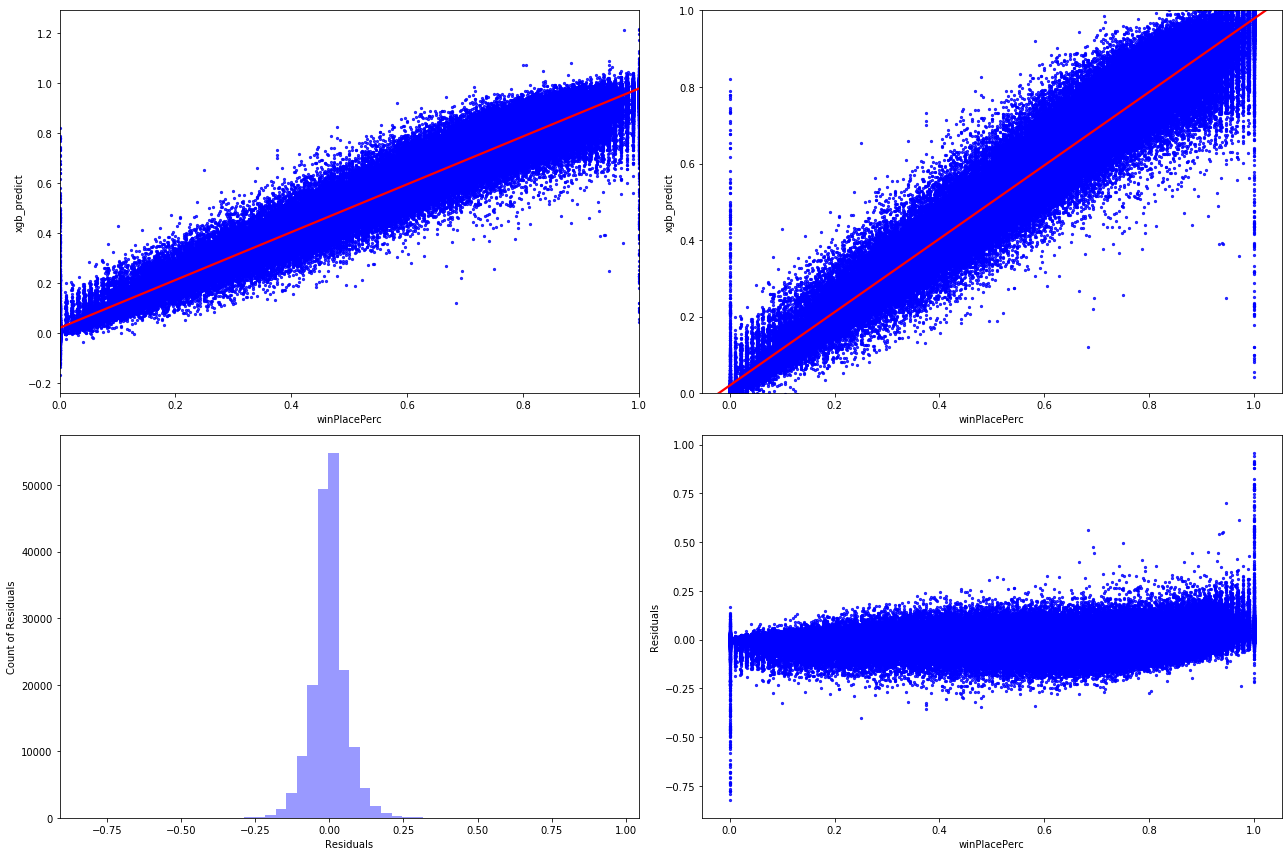

In [24]:
fig, axes = plt.subplots(2,2, figsize=(18,12))
axes = axes.flatten()
sns.regplot(x='winPlacePerc', y='xgb_predict', data=xgb_compare, color='blue', ax=axes[0], scatter_kws={'s':5}, line_kws={'color': 'red'})
axes[0].set_xlim((0,1))
sns.regplot(x='winPlacePerc', y='xgb_predict', data=xgb_compare, color='blue', ax=axes[1], scatter_kws={'s':5}, line_kws={'color': 'red'})
axes[1].set_ylim((0,1))
sns.distplot(y_test - xgb_pred, ax=axes[2], kde=False, color='blue')
axes[2].set_xlabel('Residuals')
axes[2].set_ylabel('Count of Residuals')
sns.regplot(y_test, y_test - xgb_pred, ax=axes[3], fit_reg=False, color='blue', scatter_kws={'s':5})
axes[3].set_ylabel('Residuals')

fig.tight_layout()
plt.show()

The graphs looks very similar to the RF Regression graph, however in this model the bounds of 0 and 1 don't seem to be taken into account like they were with the random forest model. Finally let's take a look at feature importance and see if it's anything like the random forest feature importance

In [25]:
feature_importances = pd.DataFrame(pd.Series(xgb_model.feature_importances_), columns=['Importance'])
feature_importances.index = X.columns
feature_importances = feature_importances.sort_values('Importance', ascending=False)
feature_importances

,Importance
walkDistance,0.731368
boosts,0.083818
killPlace,0.079264
matchDuration,0.021499
kills,0.016004
weaponsAcquired,0.013888
numGroups,0.011730
rideDistance,0.011110
maxPlace,0.005458
killStreaks,0.005434


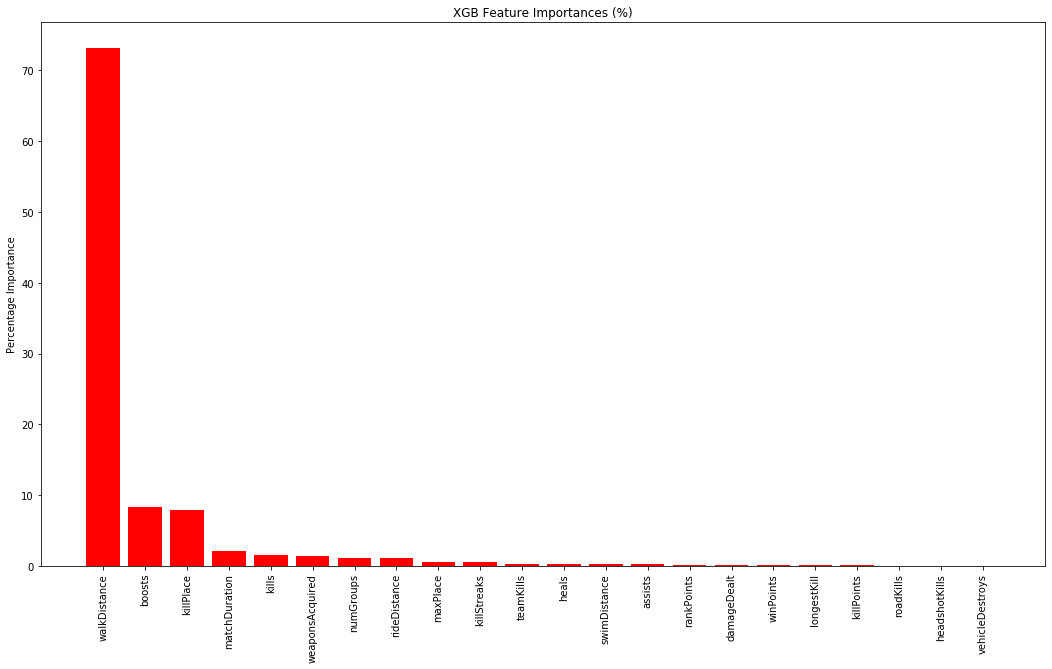

In [26]:
plt.figure(figsize=(18,10))
plt.bar(feature_importances.index, height=feature_importances['Importance'] * 100, color='r')
plt.title("XGB Feature Importances (%)")
plt.ylabel('Percentage Importance')
plt.xticks(rotation=90)
plt.show()

About the same as the random forest model. Walk distance is by far the most important, with all the rest only being of minor importance. Still unsure as to why walk distance is sucha  huge factor, that could warrant further exploration of the model.